In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')

# Load the dataset

train = pd.read_csv('/kaggle/input/test-and-train-datasets/train (1).csv')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Print column names to verify the correct columns are present
print("Column Names:", train.columns)

# Check unique values in the sentiment column to understand what labels are used
print("Unique Sentiment Labels:", train['Vader Sentiment'].unique())

Column Names: Index(['desc_id', 'source_name', 'review_text', 'is_accessibility',
       'cleanText', 'Vader Sentiment'],
      dtype='object')
Unique Sentiment Labels: ['Positive' 'Negative' 'Neutral']


In [6]:
# Remove rows with Neutral sentiment
train = train[train['Vader Sentiment'] != 'Neutral']

# Verify that 'Neutral' rows have been removed
print("Updated Sentiment Labels:", train['Vader Sentiment'].unique())

Updated Sentiment Labels: ['Positive' 'Negative']


In [ ]:
pip install matplotlib

Class Distribution:
 Vader Sentiment
Positive    1590
Negative     214
Name: count, dtype: int64


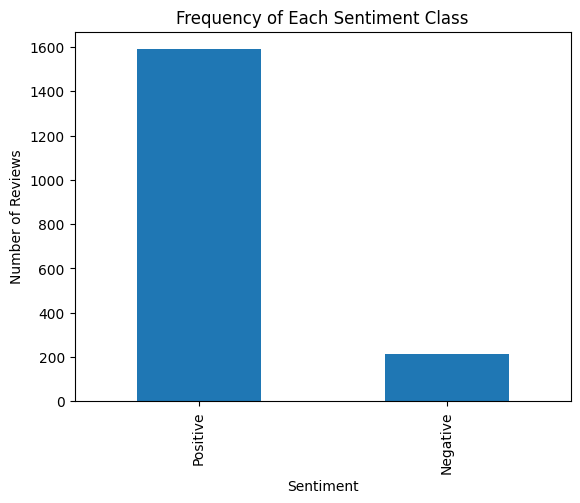

In [7]:
# Display the counts for each class to check balance
class_distribution = train['Vader Sentiment'].value_counts()
print("Class Distribution:\n", class_distribution)

# Visualize the class distribution
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar', title='Frequency of Each Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


New Balanced Class Distribution:
 Vader Sentiment
Positive    1590
Negative    1590
Name: count, dtype: int64


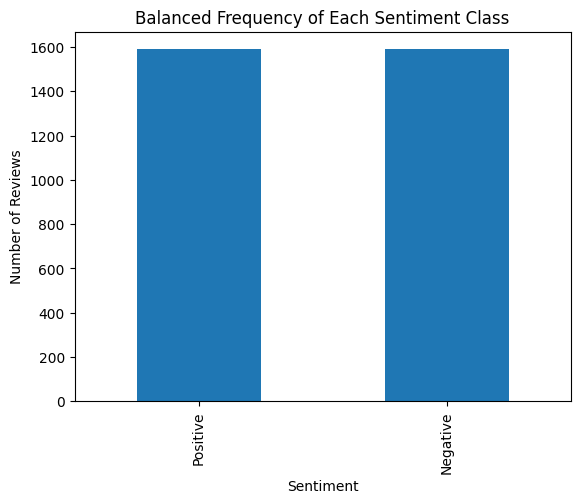

In [8]:
from sklearn.utils import resample

# Separate the majority and minority classes
positive = train[train['Vader Sentiment'] == 'Positive']
negative = train[train['Vader Sentiment'] == 'Negative']

# Upsample minority class (Negative)
negative_upsampled = resample(negative,
                              replace=True,  # sample with replacement
                              n_samples=len(positive),  # to match majority class size
                              random_state=42)  # reproducible results

# Combine the upsampled minority class with the majority class
train_balanced = pd.concat([positive, negative_upsampled])

# Shuffle the dataset to avoid any order bias
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
new_class_distribution = train_balanced['Vader Sentiment'].value_counts()
print("New Balanced Class Distribution:\n", new_class_distribution)
import matplotlib.pyplot as plt

new_class_distribution.plot(kind='bar', title='Balanced Frequency of Each Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
# Map 'Positive' to 1 and 'Negative' to 0
train_balanced['Vader Sentiment'] = train_balanced['Vader Sentiment'].map({'Positive': 1, 'Negative': 0})

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
vader_lexicon = analyzer.lexicon

# Function to extract VADER sentiment scores
def extract_vader_features(text):
    scores = analyzer.polarity_scores(text)  # Get sentiment scores
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

# Apply sentiment analysis to extract scores into new columns
train_balanced[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = train_balanced['cleanText'].apply(
    lambda x: pd.Series(extract_vader_features(x))
)
train_balanced['pos_word_count'] = train_balanced['cleanText'].apply(lambda x: sum(1 for word in x.split() if word in vader_lexicon and vader_lexicon[word] > 0))
train_balanced['neg_word_count'] = train_balanced['cleanText'].apply(lambda x: sum(1 for word in x.split() if word in vader_lexicon and vader_lexicon[word] < 0))
train_balanced['exclamation_count'] = train_balanced['cleanText'].apply(lambda x: x.count("!"))
train_balanced['avg_word_length'] = train_balanced['cleanText'].apply(lambda x: np.mean([len(word) for word in x.split()]))

train_balanced['review_length'] = train_balanced['cleanText'].apply(lambda x: len(x.split()))

# Update feature matrix X
X = train_balanced[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'review_length', 'pos_word_count', 'neg_word_count', 'exclamation_count', 'avg_word_length']]


# Verify extraction by displaying key features
print(train_balanced[['cleanText', 'vader_neg', 'vader_neu', 'vader_pos', 
                      'vader_compound', 'review_length', 'pos_word_count', 
                      'neg_word_count', 'exclamation_count', 'avg_word_length']].head())

                                           cleanText  vader_neg  vader_neu  \
0  great app wish feature request ability add not...      0.000      0.524   
1  pros named dice configurations custom icons lo...      0.095      0.705   
2  app exactly looking perfect addition termux ha...      0.062      0.753   
3  app needs volume bar playing page would deserv...      0.000      0.816   
4  thanks developer works accurately mentioned tr...      0.000      0.638   

   vader_pos  vader_compound  review_length  pos_word_count  neg_word_count  \
0      0.476          0.8442             13               3               0   
1      0.200          0.9153             98               8               4   
2      0.184          0.8625             52               3               2   
3      0.184          0.2023              9               1               0   
4      0.362          0.9643             47               8               0   

   exclamation_count  avg_word_length  
0               

In [11]:
# Load VADER Lexicon for Word-Based Embeddings
vader_lexicon = analyzer.lexicon 

print(vader_lexicon["happy"])  # Output: 2.7
print(vader_lexicon["terrible"])  # Output: -3.1

# Function to convert sentences into fixed-size numerical embeddings
def sentence_to_vader_embedding(text, max_length=1497):
    words = text.split()  # Split sentence into words
    scores = []

    for word in words:
        if word in vader_lexicon:
            scores.append(vader_lexicon[word])  # Get VADER score for the word
        else:
            scores.append(0)  # If word is not in lexicon, assign a score of 0

    # Padding: Ensure all embeddings have the same length
    if len(scores) < max_length:
        scores.extend([0] * (max_length - len(scores)))  # Pad with 0s
    else:
        scores = scores[:max_length]  # Truncate if too long

    return np.array(scores)

# Convert the 'cleanText' column into numerical embeddings
train_balanced['vader_embedding'] = train_balanced['cleanText'].apply(lambda x: sentence_to_vader_embedding(x, max_length=1497))

# Convert embeddings to a proper NumPy array
X_embeddings = np.stack(train_balanced['vader_embedding'].values)

print(train_balanced.columns)  # Print all column names to confirm


2.7
-2.1
Index(['desc_id', 'source_name', 'review_text', 'is_accessibility',
       'cleanText', 'Vader Sentiment', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'pos_word_count', 'neg_word_count',
       'exclamation_count', 'avg_word_length', 'review_length',
       'vader_embedding'],
      dtype='object')


Epoch 100/1000, Loss: 0.50955
Epoch 200/1000, Loss: 0.42063
Epoch 300/1000, Loss: 0.36805
Epoch 400/1000, Loss: 0.33285
Epoch 500/1000, Loss: 0.30735
Epoch 600/1000, Loss: 0.28786
Epoch 700/1000, Loss: 0.27236
Epoch 800/1000, Loss: 0.25967
Epoch 900/1000, Loss: 0.24905
Epoch 1000/1000, Loss: 0.23998


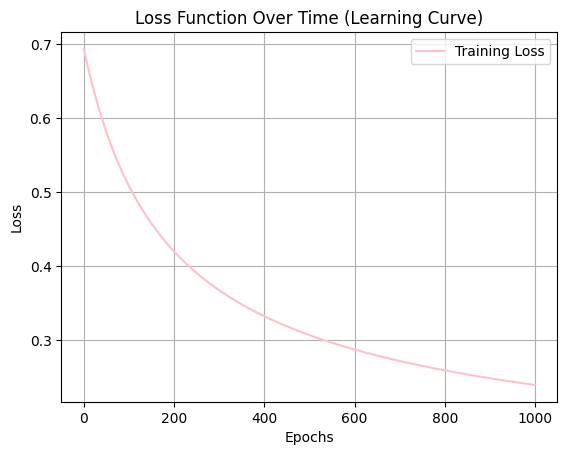


Final Validation Accuracy: 0.9355
Training Accuracy: 0.9320


In [12]:
train_balanced['binary_sentiment'] = train_balanced['vader_compound'].apply(lambda x: 1 if x >= 0.05 else 0)

y = train_balanced['binary_sentiment']
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#  Split the data FIRST (before scaling)
X_train, X_val, y_train, y_val = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)


# Initialize StandardScaler
scaler = StandardScaler()

#  Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform on training data
X_val_scaled = scaler.transform(X_val)  # Only transform validation data (no fitting)

#  Implement Logistic Regression with Gradient Descent
import numpy as np

def logistic_regression_with_tracking(X, y, lr=0.01, epochs=1000):
    weights = np.zeros(X.shape[1] + 1)  # Initialize weights (including bias)
    losses = []  # List to store loss values

    for epoch in range(epochs):
        z = np.dot(X, weights[1:]) + weights[0]  # Linear function
        p = 1 / (1 + np.exp(-z))  # Sigmoid function
        error = p - y  # Compute error
        loss = -np.mean(y * np.log(p + 1e-9) + (1 - y) * np.log(1 - p + 1e-9))  # Binary cross-entropy loss
        losses.append(loss)  # Store loss

        gradient = np.dot(X.T, error) / len(y)  # Compute gradient
        weights[1:] -= lr * gradient  # Update weights
        weights[0] -= lr * np.mean(error)  # Update bias

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.5f}")

    return weights, losses  # Return both weights and loss history

weights, loss_history = logistic_regression_with_tracking(X_train_scaled, y_train, epochs=1000)

plt.plot(loss_history, label="Training Loss", color='pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function Over Time (Learning Curve)")
plt.legend()
plt.grid()
plt.show()





#  Evaluate model on validation set
z_val = np.dot(X_val_scaled, weights[1:]) + weights[0]  # Compute predictions
y_pred = (1 / (1 + np.exp(-z_val))) >= 0.5  # Apply classification threshold

#  Calculate accuracy
accuracy = np.mean(y_pred == y_val)
print(f"\nFinal Validation Accuracy: {accuracy:.4f}")
z_train = np.dot(X_train_scaled, weights[1:]) + weights[0]
y_train_pred = (1 / (1 + np.exp(-z_train))) >= 0.5
train_accuracy = np.mean(y_train_pred == y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")


In [13]:
from joblib import dump

# Save the model weights
dump(weights, 'logistic_regression_weights.joblib')

# Save the scaler
dump(scaler, 'standard_scaler.joblib')


['standard_scaler.joblib']

In [14]:
from sklearn.metrics import accuracy_score, classification_report

#  Prediction Function
def predict(X, weights):
    z = np.dot(X, weights[1:]) + weights[0]
    probabilities = 1 / (1 + np.exp(-z))  # Apply sigmoid function
    return (probabilities >= 0.5).astype(int)  # Convert to binary labels (0 or 1)

# Make predictions on validation data
predictions = predict(X_val_scaled, weights)

#  Evaluate the model
accuracy = accuracy_score(y_val, predictions)

print("\nClassification Report:\n", classification_report(y_val, predictions))



Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       299
           1       0.97      0.91      0.94       337

    accuracy                           0.94       636
   macro avg       0.94      0.94      0.94       636
weighted avg       0.94      0.94      0.94       636



In [15]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


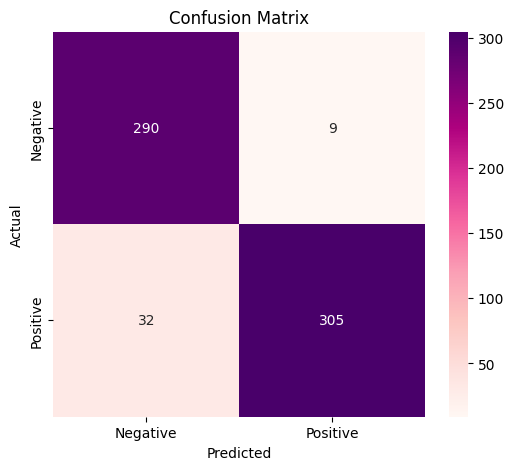

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_val, predictions)


# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# Load test dataset (Update the path if needed)
test_path = "/kaggle/input/test-and-train-datasets/test.csv"
test = pd.read_csv(test_path)


# Check if test_data is loaded correctly
print(test.head())


   desc_id                                        source_name  \
0        1  gp_AOqpTOGrphtVjrB_Udf0Mg-Fb_uFHMpCJyxMRPGZvwk...   
1        1  gp_AOqpTOGscxyOhbcCo0Lgj-cyvdO5VJRPgRg42S4gr1-...   
2        1  gp_AOqpTOGTbz6wfmSUzPTxKdubTzn3tVx00D9GU6yxuTs...   
3        1  gp_AOqpTOGU444Ao-q5YbeX4g4jiml1NX999cK-7O53aqa...   
4        1  gp_AOqpTOGUA3EUD0njqe8phB4M0CCo3N4cHDsYeU2N6dG...   

                                         review_text      is_accessibility  \
0   I have a problem with your app. Running the l...  Accessibility Review   
1   I've been using this app for a few weeks now ...  Accessibility Review   
2   I prefer Cool Reader (CR) to Aldiko. CR chang...  Accessibility Review   
3  Missing the ability to invert colour of images...  Accessibility Review   
4  Cool Reader allows more customizations than ha...  Accessibility Review   

                                           cleanText  
0  problem app running last version app google pl...  
1  using app weeks everything 

In [18]:
# Ensure test embeddings are created
test['vader_embedding'] = test['cleanText'].apply(lambda x: sentence_to_vader_embedding(x, max_length=1497))

# Convert embeddings to numpy array
X_test_embeddings = np.stack(test['vader_embedding'].values)

# Scale the test embeddings using the same scaler as training data
X_test_scaled = scaler.transform(X_test_embeddings)  # Do NOT fit again

# Compute predictions on the test set
z_test = np.dot(X_test_scaled, weights[1:]) + weights[0]
test_predictions = (1 / (1 + np.exp(-z_test))) >= 0.5  # Apply threshold

# Convert boolean predictions to integers (0 or 1)
test_predictions = test_predictions.astype(int)


In [19]:
submission = pd.DataFrame({'id': test.index, 'Vader_Binary_Sentiment': test_predictions})
submission.to_csv('mimisubmission.csv', index=False)

print("✅ Submission file saved successfully!")


✅ Submission file saved successfully!


In [20]:
# Compare validation and test class distributions
val_unique, val_counts = np.unique(y_val, return_counts=True)
test_unique, test_counts = np.unique(test_predictions, return_counts=True)

print("Validation Set Distribution:", dict(zip(val_unique, val_counts)))
print("Test Set Distribution:", dict(zip(test_unique, test_counts)))


Validation Set Distribution: {0: 299, 1: 337}
Test Set Distribution: {0: 119, 1: 475}
